# Sample Prediction Model

## Set Variables
***

In [1]:
# Load Data Variables
explanatory_variable = ["sex", "age", "odds"]

# Grid Search Variables
score = "recall" # recall / precision
params = {"kernel":["rbf"], "C":[1, 10, 100]}

# Model Name
model_title = "sample"

## Create Model
***
#### Load Analysis Data
Load data from result table, then add calculated variables.

In [2]:
from umap.uhelper import pd_result
import numpy as np
import pandas as pd

def load_analysis_data(training, exp):
    # Load explanatory variables
    df = pd_result(exp, training)
    
    # convert sex val to dummy vals
    dmy_sex = pd.get_dummies(df.sex)
    df = pd.concat([df, dmy_sex], axis=1)
    df = df.drop("sex", axis=1)
    df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})
    
    # Create and concat objection variables (<3 is False, 3< is True)
    if training:
        results = pd_result(["rank"], training)
        results["target"] = np.where(results["rank"]<=3, False, True)
        results = results.drop("rank", axis=1)        
        df = pd.concat([results, df], axis=1, sort=True)
    
    # Remove missing data
    df = df.dropna()   
    return df

# Load entry data (Past data)
df = load_analysis_data(True, explanatory_variable)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159504 entries, 2015030101012012100032 to 2018100212122015106167
Data columns (total 6 columns):
target     159504 non-null bool
age        159504 non-null int64
odds       159504 non-null float64
gelding    159504 non-null uint8
female     159504 non-null uint8
male       159504 non-null uint8
dtypes: bool(1), float64(1), int64(1), uint8(3)
memory usage: 4.3+ MB


#### Train Prediction Model
Split data and training

In [3]:
from sklearn.model_selection import train_test_split

# Split dataframe to training data and test data
X = df.drop(["target"], axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 78.5min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 192.6min remaining: 96.3min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 478.6min remaining: 119.6min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 675.3min finished



+ Best Parameter:

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

+ Classification Report:

              precision    recall  f1-score   support

       False       0.40      0.78      0.53      8273
        True       0.92      0.70      0.80     31603

   micro avg       0.72      0.72      0.72     39876
   macro avg       0.66      0.74      0.66     39876
weighted avg       0.82      0.72      0.74     39876


+ Confusion Matrix:



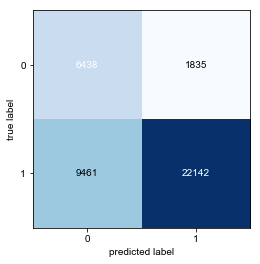

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
%matplotlib inline

svc = SVC(gamma="scale", class_weight="balanced")
clf = GridSearchCV(svc, params, cv=5, scoring=score, n_jobs=-1, verbose=10)
clf.fit(X_train, y_train)

print("\n+ Best Parameter:\n")
print(clf.best_estimator_)

print("\n+ Classification Report:\n")
y_test, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_test, y_pred))

print("\n+ Confusion Matrix:\n")
cnf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.style.use('seaborn-dark')
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix

tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

p = Pmodel()
p.title = model_title
p.model_bin = clf
p.method = "SVC"
p.columns = ','.join(explanatory_variable)
p.recall = round(tp / (tp + fn), 3)
p.precision = round(tp / (tp + fp), 3)
p.note = clf.best_estimator_
p.save()

Pmodel.objects.filter(title=p.title).values("title", "method", "recall", "precision", "note")

<QuerySet [{'title': 'sample', 'method': 'SVC', 'recall': 0.778, 'precision': 0.405, 'note': "SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,\n  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)"}]>

## Apply Model
***
#### Load Analysis Data
Load data from result table, then add calculated variables.

In [1]:
# Load model
p = Pmodel.objects.get(pk=model_title)
cols = p.columns.split(',')
clf = p.model_bin

In [2]:
from umap.uhelper import pd_result
import numpy as np
import pandas as pd

def load_analysis_data(training, exp):
    # Load explanatory variables
    df = pd_result(exp, training)
    
    # convert sex val to dummy vals
    dmy_sex = pd.get_dummies(df.sex)
    df = pd.concat([df, dmy_sex], axis=1)
    df = df.drop("sex", axis=1)
    df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})
    
    # Create and concat objection variables (<3 is False, 3< is True)
    if training:
        results = pd_result(["rank"], training)
        results["target"] = np.where(results["rank"]<=3, False, True)
        results = results.drop("rank", axis=1)        
        df = pd.concat([results, df], axis=1, sort=True)
    
    # Remove missing data
    df = df.dropna()   
    return df

# Load entry data (Past data)
entry = load_analysis_data(False, cols)
#df.info()

In [3]:
import pandas as pd

# Concat Entry data and Result Data
# NOTE: 'Id like to get prediction result of PAST and FUTURE races , so I'll do below command.
df = load_analysis_data(True, cols)
df = df.drop(["target"], axis=1)
df = pd.concat([df, entry], sort=True)

#### Apply Model

In [4]:
# Apply model
y = clf.predict(df)
exp = pd.Series(y, index=df.index, name='expect')

# Concat toggled prediction result to dataframe
df = pd.concat([df, ~exp], axis=1)
df.head()

,age,female,gelding,male,odds,expect
key,,,,,,
2013020101012010100303,3,1,0,0,183.6,False
2013020101012010101023,3,1,0,0,106.1,False
2013020101012010101355,3,1,0,0,3.5,True
2013020101012010101877,3,1,0,0,24.2,False
2013020101012010102642,3,1,0,0,61.3,False


#### Delete & Insert Predction Resules

In [6]:
from django.db import transaction
from tqdm._tqdm_notebook import tqdm_notebook

@transaction.atomic
def insert_prediction(_df):
    for index, row in tqdm_notebook(_df.iterrows(), total=_df.shape[0]):
        exp = Expect()
        exp.result = Result.objects.get(pk=index)
        exp.pm_name=model_title
        exp.clf_result=row.expect
        exp.save()

tqdm_notebook.pandas()
# Delete existing
Expect.objects.filter(pm_name=model_title).delete()
# Insert Prediction Results
insert_prediction(df)

## Evaluate Model
***
#### Load Expect Data
Load data from expect table by month.

In [5]:
import pandas as pd
from datetime import datetime, timedelta

# Get Race date in the last year 
from_dt = datetime.now() - timedelta(weeks=53)
races = Race.objects.filter(result_flg=True, race_dt__gte=from_dt).order_by('race_dt').distinct('race_dt').values_list('race_dt', flat=True)

summary_list = list()
for day in races:
    results = Result.objects.filter(expect__clf_result=True, expect__pm_name=model_title, race__race_dt=day).exclude(rank=0).values("rank", "odds")
    expect_cnt = len(results)
    hit_cnt = len([result for result in results if result["rank"] == 1])
    hit_rate = round(hit_cnt/expect_cnt * 100, 2)
    pay_amt = len([result for result in results]) * 100
    refund_amt = int(sum([result["odds"] * 100 for result in results if result["rank"] == 1]))
    rtn_rate = round(refund_amt / pay_amt * 100, 2)
    summary_list.append([day, expect_cnt, hit_cnt, hit_rate, pay_amt, refund_amt, rtn_rate])

summary = pd.DataFrame(summary_list, columns=["race_dt", "expect_count", "hit_count", "hit_rate", "pay_amount", "refund_amount", "return_rate"])
summary = summary.set_index("race_dt")
summary.head()

,expect_count,hit_count,hit_rate,pay_amount,refund_amount,return_rate
race_dt,,,,,,
2017-12-23,108,21,19.44,10800,9700,89.81
2017-12-24,107,19,17.76,10700,8760,81.87
2017-12-28,109,20,18.35,10900,11580,106.24
2018-01-06,121,19,15.70,12100,8200,67.77
2018-01-07,122,18,14.75,12200,10500,86.07


Hit Rate: 17.15 %
Payment: ¥1663700 / Refund: ¥1377140 / Return Rate: 82.56 %


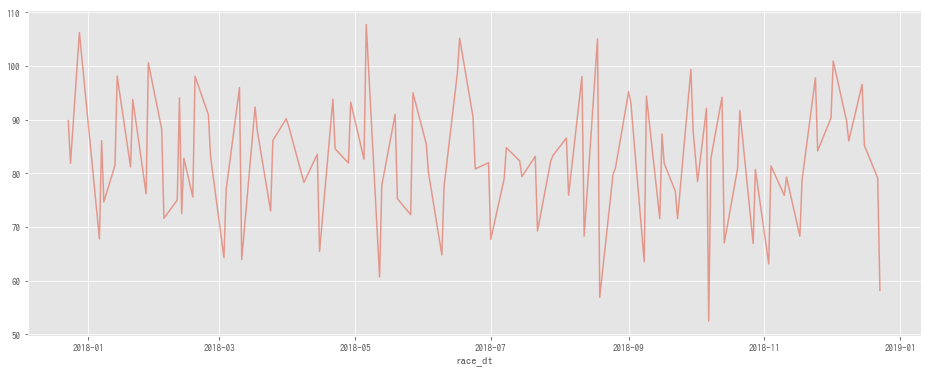

In [7]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Set Japanese Font
plt.style.use('ggplot') 
matplotlib.rcParams["font.family"] = "IPAGothic"
matplotlib.rcParams["font.size"] = 9

print("Hit Rate: "+str(round(summary["hit_rate"].mean(), 2))+" %")
print("Payment: ¥"+str(summary["pay_amount"].sum()), end="")
print(" / Refund: ¥"+str(summary["refund_amount"].sum()), end="")
print(" / Return Rate: "+str(round(summary["return_rate"].mean(), 2))+" %")
p = Pmodel.objects.get(pk=model_title)
p.roi = round(summary["return_rate"].mean(), 2)
p.save()

summary["return_rate"].plot(figsize=(16,6), alpha=0.5)